In [ ]:
class BaseCache:
    def __init__(self, capacity):
        self.capacity = capacity
        self.cache = {}

    def get(self, key):
        raise NotImplementedError

    def put(self, key, value):
        raise NotImplementedError

    def __len__(self):
        return len(self.cache)

In [ ]:
from collections import deque

class FIFOCache(BaseCache):
    def __init__(self, capacity):
        super().__init__(capacity)
        self.queue = deque()

    def get(self, key):
        return self.cache.get(key, None)

    def put(self, key, value):
        if key in self.cache:
            return

        if len(self.cache) >= self.capacity:
            oldest = self.queue.popleft()
            del self.cache[oldest]

        self.cache[key] = value
        self.queue.append(key)

In [ ]:
from collections import OrderedDict

class LRUCache(BaseCache):
    def __init__(self, capacity):
        super().__init__(capacity)
        self.cache = OrderedDict()

    def get(self, key):
        if key not in self.cache:
            return None
        self.cache.move_to_end(key)
        return self.cache[key]

    def put(self, key, value):
        if key in self.cache:
            self.cache.move_to_end(key)
        elif len(self.cache) >= self.capacity:
            self.cache.popitem(last=False)
        self.cache[key] = value

In [ ]:
from collections import defaultdict

class LFUCache(BaseCache):
    def __init__(self, capacity):
        super().__init__(capacity)
        self.freq = defaultdict(int)
        self.time = 0
        self.timestamp = {}

    def get(self, key):
        if key not in self.cache:
            return None
        self.freq[key] += 1
        return self.cache[key]

    def put(self, key, value):
        if self.capacity == 0:
            return

        if key in self.cache:
            self.cache[key] = value
            self.freq[key] += 1
            return

        if len(self.cache) >= self.capacity:
            min_freq = min(self.freq.values())
            candidates = [k for k in self.cache if self.freq[k] == min_freq]
            evict = candidates[0]
            del self.cache[evict]
            del self.freq[evict]

        self.cache[key] = value
        self.freq[key] = 1

In [ ]:
cache = LRUCache(capacity=2)
cache.put(1, "A")
cache.put(2, "B")
cache.get(1)
cache.put(3, "C")

print(cache.cache)

OrderedDict({1: 'A', 3: 'C'})


In [ ]:
import random
import numpy as np

class WorkloadGenerator:
    def __init__(self, num_items, num_requests, seed=42):
        self.num_items = num_items
        self.num_requests = num_requests
        random.seed(seed)
        np.random.seed(seed)

    def generate(self):
        raise NotImplementedError

In [ ]:
class UniformWorkload(WorkloadGenerator):
    def generate(self):
        return [
            random.randint(0, self.num_items - 1)
            for _ in range(self.num_requests)
        ]

In [ ]:
class ZipfWorkload(WorkloadGenerator):
    def __init__(self, num_items, num_requests, alpha=1.2, seed=42):
        super().__init__(num_items, num_requests, seed)
        self.alpha = alpha

    def generate(self):
        ranks = np.arange(1, self.num_items + 1)
        probs = 1 / np.power(ranks, self.alpha)
        probs /= probs.sum()

        return np.random.choice(
            self.num_items,
            size=self.num_requests,
            p=probs
        ).tolist()

In [ ]:
class ChangingPopularityWorkload(WorkloadGenerator):
    def generate(self):
        requests = []
        half = self.num_requests // 2

        # Phase 1: items 0–9 are hot
        for _ in range(half):
            if random.random() < 0.8:
                requests.append(random.randint(0, 9))
            else:
                requests.append(random.randint(10, self.num_items - 1))

        # Phase 2: items 10–19 become hot
        for _ in range(self.num_requests - half):
            if random.random() < 0.8:
                requests.append(random.randint(10, 19))
            else:
                requests.append(random.randint(0, self.num_items - 1))

        return requests

In [ ]:
wl = ZipfWorkload(num_items=50, num_requests=1000)
requests = wl.generate()

print(requests[:20])
print("Unique items:", len(set(requests)))

[1, 35, 9, 4, 0, 0, 0, 20, 4, 8, 0, 40, 16, 0, 0, 0, 1, 3, 1, 0]
Unique items: 49


In [ ]:
import time

class Metrics:
    def __init__(self):
        self.hits = 0
        self.misses = 0
        self.total_requests = 0
        self.response_times = []

    def record_hit(self, response_time):
        self.hits += 1
        self.total_requests += 1
        self.response_times.append(response_time)

    def record_miss(self, response_time):
        self.misses += 1
        self.total_requests += 1
        self.response_times.append(response_time)

    def hit_ratio(self):
        return self.hits / self.total_requests if self.total_requests else 0

    def avg_response_time(self):
        return sum(self.response_times) / len(self.response_times) if self.response_times else 0

In [ ]:
CACHE_HIT_TIME = 1      # arbitrary units
BACKEND_ACCESS_TIME = 10

In [ ]:
def run_simulation(cache, requests):
    metrics = Metrics()

    for key in requests:
        start = time.perf_counter()

        value = cache.get(key)
        if value is not None:
            # Cache hit
            time.sleep(0)
            end = start + CACHE_HIT_TIME
            metrics.record_hit(end - start)
        else:
            # Cache miss → fetch from backend
            time.sleep(0)
            cache.put(key, key)
            end = start + BACKEND_ACCESS_TIME
            metrics.record_miss(end - start)

    return metrics

In [ ]:
cache = LRUCache(capacity=50)
workload = ZipfWorkload(num_items=100, num_requests=5000)
requests = workload.generate()

metrics = run_simulation(cache, requests)

print("Hit ratio:", metrics.hit_ratio())
print("Avg response time:", metrics.avg_response_time())

Hit ratio: 0.8776
Avg response time: 2.1016


In [ ]:
def compare_policies(cache_classes, workload):
    results = {}

    requests = workload.generate()

    for name, cache_class in cache_classes.items():
        cache = cache_class
        metrics = run_simulation(cache, requests)
        results[name] = {
            "hit_ratio": metrics.hit_ratio(),
            "avg_response_time": metrics.avg_response_time()
        }

    return results

In [ ]:
cache_policies = {
    "FIFO": FIFOCache(capacity=50),
    "LRU": LRUCache(capacity=50),
    "LFU": LFUCache(capacity=50)
}

wl = ZipfWorkload(num_items=100, num_requests=5000)
results = compare_policies(cache_policies, wl)

results

{'FIFO': {'hit_ratio': 0.8354, 'avg_response_time': 2.4814},
 'LRU': {'hit_ratio': 0.8776, 'avg_response_time': 2.1016},
 'LFU': {'hit_ratio': 0.894, 'avg_response_time': 1.954}}

In [ ]:
def experiment_cache_sizes(cache_classes, workload_class, cache_sizes,
                           num_items=100, num_requests=10000):
    results = {name: [] for name in cache_classes}

    for size in cache_sizes:
        workload = workload_class(num_items, num_requests)
        requests = workload.generate()

        for name, cache_class in cache_classes.items():
            cache = cache_class(size)
            metrics = run_simulation(cache, requests)
            results[name].append(metrics.hit_ratio())

    return results

In [ ]:
cache_policies = {
    "FIFO": FIFOCache,
    "LRU": LRUCache,
    "LFU": LFUCache
}

cache_sizes = [10, 20, 40, 60, 80]

results = experiment_cache_sizes(
    cache_policies,
    ZipfWorkload,
    cache_sizes
)

results

{'FIFO': [0.4924, 0.6484, 0.7984, 0.884, 0.9456],
 'LRU': [0.5601, 0.7119, 0.8442, 0.9145, 0.9608],
 'LFU': [0.651, 0.7802, 0.8674, 0.9276, 0.9649]}

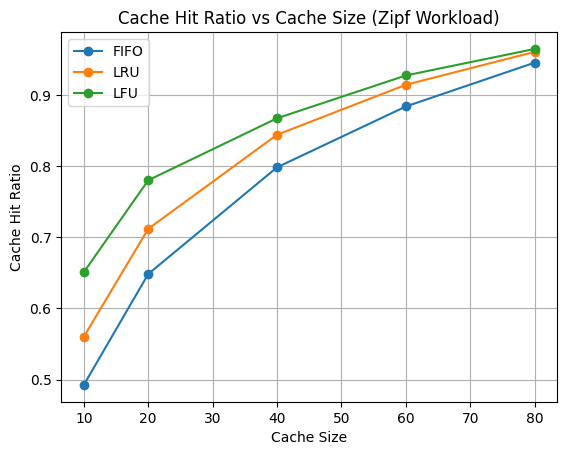

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
for policy, hit_rates in results.items():
    plt.plot(cache_sizes, hit_rates, marker='o', label=policy)

plt.xlabel("Cache Size")
plt.ylabel("Cache Hit Ratio")
plt.title("Cache Hit Ratio vs Cache Size (Zipf Workload)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
uniform_results = experiment_cache_sizes(
    cache_policies,
    UniformWorkload,
    cache_sizes
)

In [ ]:
changing_results = experiment_cache_sizes(
    cache_policies,
    ChangingPopularityWorkload,
    cache_sizes
)

In [ ]:
def throughput(metrics):
    return metrics.total_requests / sum(metrics.response_times)